Activities with >80% False motion_value:
PID: P06, Activity: FFSIT, Proportion of False: 1.00
PID: P11, Activity: FFSIT, Proportion of False: 0.96


/var/folders/xt/j055vd5n66x6nhkm2f0zzg2w0000gn/T/ipykernel_60001/383204456.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])


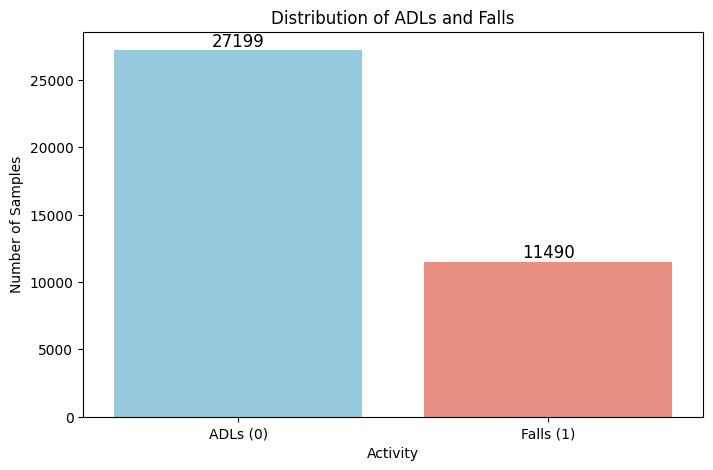

Index(['timestamp', 'motion_value', 'light', 'temp', 'breathingRate',
       'heartRate', 'physiologicalState', 'targetDistance_filtered',
       'health_idx', 'PID', 'activity_name', 'class', 'base_activity',
       'environmental_index'],
      dtype='object')


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, LSTM, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def remove_zero_readings(df, threshold=10):
    """Remove records with zero readings above threshold."""
    # Track problematic sensor combinations
    zero_readings = pd.DataFrame()
    for sensor in ['breathingRate', 'heartRate']:
        zero_counts = df[df[sensor] == 0.0].groupby(['PID', 'activity_name'])[sensor].count()
        zero_readings = pd.concat([zero_readings, zero_counts[zero_counts > threshold]])
    
    # Remove identified problematic records
    outlier_indices = zero_readings.index.drop_duplicates()
    return df[~df.set_index(['PID', 'activity_name']).index.isin(outlier_indices)]


df = pd.read_csv("combined_sensor_data-all-7.csv")

# ignore one hot encoded and netatmo and static 
# health_idx_columns = ['health_idx_0', 'health_idx_1', 'health_idx_2', 'health_idx_3', 'health_idx_4']
# physiologicalState_columns = ['physiologicalState_0', 'physiologicalState_1', 'physiologicalState_2','physiologicalState_3', 'physiologicalState_4']
# df = df.drop(['targetDistance','CO2','Humidity','Noise','Pressure','AbsolutePressure',
            #   'age','gender','height','weight','fitness_level'] + physiologicalState_columns + health_idx_columns, axis=1)

# remove redundant 
df = df.drop(['targetDistance', 'AbsolutePressure'], axis=1)

# feature engineering 
def combine_ambient(df, ambient_features):
    # Step 1: Select only ambient sensor features (CO2, Humidity, Noise, Pressure)
    ambient_df = df[ambient_features]

    # Step 2: Handle NaN values by filling with the mean
    ambient_df = ambient_df.fillna(ambient_df.mean())

    # Step 3: Standardize the ambient sensor features
    scaler = StandardScaler()
    ambient_features_scaled = scaler.fit_transform(ambient_df)
    # Step 4: Apply PCA to create the Environmental Index
    pca = PCA(n_components=1)  # Aggregate into a single component
    env_index = pca.fit_transform(ambient_features_scaled)
    # Add the Environmental Index to the original DataFrame
    df['environmental_index'] = env_index
    # Display the updated DataFrame
    # df.drop(ambient_features)
    # print(df.columns)
    df = df.drop(ambient_features, axis=1)
    return df


# Define the activities
fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]
non_fall_activities = ["LOB", "RS", "SBS", "SIT", "SSS", 'SSW', "SWW", "TWC", "WAT", 'WSS']
ambient_features = ['CO2', 'Humidity', 'Noise', 'Pressure']

def remove_low_motion_activities(df, threshold=0.8):
    """
    Print and remove fall activities where motion_value is False 
    for more than the threshold percentage of the activity's duration.
    """
    # List of fall activities to check
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Filter for fall activities only
    falls_df = df[df['activity_name'].isin(fall_activities)]

    # Calculate percentage of False motion values for each (PID, activity_name)
    motion_stats = (
        falls_df.groupby(['PID', 'activity_name'])['motion_value']
        .apply(lambda x: (x == False).mean())  # Calculate proportion of False values
    )

    # Identify activities to print and remove based on the threshold
    activities_to_remove = motion_stats[motion_stats > threshold]

    # Print the activity names and their proportions before removing
    print("Activities with >80% False motion_value:")
    for (pid, activity_name), proportion in activities_to_remove.items():
        print(f"PID: {pid}, Activity: {activity_name}, Proportion of False: {proportion:.2f}")

    # Remove identified activities from the DataFrame
    return df[~df.set_index(['PID', 'activity_name']).index.isin(activities_to_remove.index)]

def identify_and_remove_outliers_combined(df):
    """
    Identify outliers for both ADL and Fall activities using IQR and remove them from the dataset.
    Retain all other information and merge cleaned activities back.
    """
    # Group by base_activity, class, and PID to calculate the duration per activity
    duration_counts = df.groupby(['base_activity', 'class', 'PID']).size().reset_index(name='duration')

    # Separate ADLs and Falls
    adls = duration_counts[duration_counts['class'] == 0]  # ADL activities
    falls = duration_counts[duration_counts['class'] == 1]  # Fall activities

    # Helper function to identify and clean outliers using IQR
    def clean_outliers(data):
        outliers = []
        cleaned_data = []

        for activity in data['base_activity'].unique():
            activity_data = data[data['base_activity'] == activity]
            Q1 = activity_data['duration'].quantile(0.25)
            Q3 = activity_data['duration'].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers and non-outliers
            activity_outliers = activity_data[
                (activity_data['duration'] < lower_bound) | (activity_data['duration'] > upper_bound)
            ]
            activity_cleaned = activity_data[
                (activity_data['duration'] >= lower_bound) & (activity_data['duration'] <= upper_bound)
            ]

            outliers.append(activity_outliers)
            cleaned_data.append(activity_cleaned)

        # Combine all outliers and cleaned data
        all_outliers = pd.concat(outliers, ignore_index=True)
        all_cleaned_data = pd.concat(cleaned_data, ignore_index=True)

        return all_outliers, all_cleaned_data

    # Clean outliers for ADLs and Falls separately
    adl_outliers, cleaned_adls = clean_outliers(adls)
    fall_outliers, cleaned_falls = clean_outliers(falls)

    # Print identified outliers
    print("\nIdentified ADL Outliers:")
    print(adl_outliers[['base_activity', 'PID', 'duration']])

    print("\nIdentified Fall Outliers:")
    print(fall_outliers[['base_activity', 'PID', 'duration']])

    # Combine cleaned ADLs and Falls
    cleaned_df = pd.concat([cleaned_adls, cleaned_falls], ignore_index=True)

    # Merge cleaned activities with the original DataFrame to retain all columns
    final_df = df.merge(cleaned_df[['base_activity', 'PID']], on=['base_activity', 'PID'], how='inner')

    return final_df


# 2. Apply cleaning steps
df = remove_zero_readings(df)
df['motion_value'] = df['motion_value'].astype(int)
df = remove_low_motion_activities(df)
# df_2 = identify_and_remove_outliers_combined(df)

df_clean = df.drop(ambient_features, axis=1)
df_ambient = combine_ambient(df, ambient_features)

def filter_activities(df):
    # Define relevant fall activities
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    non_fall_activities = [
            "LOB", "RS", "SBS", 
            "SWW", "TWC", "WAT", 
            'WSS', 'SSW', 'SSS'
        ]

    # Filter the dataset to keep only relevant activities
    df_filtered = df[df['base_activity'].isin(fall_activities + non_fall_activities)]
    return df_filtered

final_df_clean = filter_activities(df_clean)
final_df_ambient = filter_activities(df_ambient)

def plot_class_distribution(df):
    """
    Plot the distribution of ADLs (class=0) and Falls (class=1) with sample counts.
    """
    # Get the class distribution
    class_counts = df['class'].value_counts().reset_index()
    class_counts.columns = ['class', 'count']
    class_counts['label'] = class_counts['class'].apply(lambda x: 'ADLs (0)' if x == 0 else 'Falls (1)')

    # Plot the distribution using a bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])

    # Add labels on top of the bars
    for index, row in class_counts.iterrows():
        plt.text(index, row['count'], f'{row["count"]}', ha='center', va='bottom', fontsize=12)

    # Add plot labels and title
    plt.title("Distribution of ADLs and Falls")
    plt.xlabel("Activity")
    plt.ylabel("Number of Samples")
    plt.show()

plot_class_distribution(df_clean)

# final_df
# 19195/10583
# print(len(final_df_clean.columns)) # 14 features
# print(final_df_clean.columns) # 14 features
print(final_df_ambient.columns) # 14 features
# print(df_clean.columns) # 14 features with all ADLs

# print(df_clean.shape)
# print(final_df_clean.shape)

# ResNet

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Input, BatchNormalization, Activation, Add, GlobalAveragePooling1D

def residual_block(input_tensor, filters, kernel_size, stride=1):
    # Shortcut connection (identity)
    shortcut = input_tensor

    # First layer of the block
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second layer of the block
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the output of the block
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def build_resnet(input_shape, num_blocks=3, filters=32, kernel_size=3):
    inputs = Input(shape=input_shape)

    # Initial Conv1D layer before the residual blocks
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add residual blocks
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size)

    # Global average pooling and output layer
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

#  input shape: (time_steps, features)
# input_shape = (window_size, X_train.shape[2])
# resnet_model = build_resnet(input_shape, num_blocks=3, filters=32, kernel_size=3)
# resnet_model.summary()

In [4]:
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import ADASYN
from typing import Tuple
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# plt.style.use('classic')

def plot_advanced_metrics(y_test, y_pred_probs, model_name="CNN Model"):
    """
    Create publication-quality ROC and Precision-Recall curves
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    avg_precision = average_precision_score(y_test, y_pred_probs)
    
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
    ax2.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2, linestyle='--',
                label='Random classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    # plt.tight_layout()
    # plt.savefig('advanced_metrics.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return roc_auc, avg_precision

def analyze_threshold_impact(y_test, y_pred_probs):
    """
    Analyze impact of different classification thresholds using numpy operations
    """
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix elements using numpy
        tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
        fp = np.sum(np.logical_and(y_test == 0, y_pred == 1))
        fn = np.sum(np.logical_and(y_test == 1, y_pred == 0))
        tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # Plot threshold impact
    plt.figure(figsize=(10, 6))
    thresholds = [r['threshold'] for r in results]
    plt.plot(thresholds, [r['precision'] for r in results], 
             label='Precision', marker='o')
    plt.plot(thresholds, [r['recall'] for r in results], 
             label='Recall', marker='s')
    plt.plot(thresholds, [r['f1'] for r in results], 
             label='F1-score', marker='^')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Impact of Classification Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.tight_layout()
    # plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return results

def find_optimal_threshold(results):
    """Find threshold with highest F1 score"""
    return max(results, key=lambda x: x['f1'])['threshold']

def format_threshold_results(results):
    """Format threshold results as string"""
    text = ""
    for r in results:
        text += f"\n   Threshold {r['threshold']:.1f}:"
        text += f" Precision={r['precision']:.3f},"
        text += f" Recall={r['recall']:.3f},"
        text += f" F1={r['f1']:.3f}"
    return text

def evaluate_model_advanced(model, X_test, y_test):
    """
    Main function to generate all advanced metrics
    """
    # Get predictions and ensure they're the right shape
    y_pred_probs = model.predict(X_test, verbose=0)
    if len(y_pred_probs.shape) > 1 and y_pred_probs.shape[1] == 1:
        y_pred_probs = y_pred_probs.ravel()
    
    # Generate ROC and PR curves
    roc_auc, avg_precision = plot_advanced_metrics(y_test, y_pred_probs)
    
    # Analyze threshold impact
    threshold_results = analyze_threshold_impact(y_test, y_pred_probs)
    
    # Generate summary
    summary = f"""
    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): {roc_auc:.4f}

    2. Precision-Recall Analysis:
    - Average Precision (AP): {avg_precision:.4f}

    3. Threshold Analysis:
    Optimal threshold based on F1-score: {find_optimal_threshold(threshold_results):.2f}
    
    Performance at different thresholds:
    {format_threshold_results(threshold_results)}
    """
    
    print(summary)
    return roc_auc, avg_precision, threshold_results


# new
def create_sliding_windows2(data, window_size=10, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)

        # Handle any NaN values resulting from coercion
        # group = group.fillna(0)  # Replace NaN values with 0 or use other imputation methods

        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window
    return np.array(windows), np.array(labels)


def normalize_window(window):
    """Normalize each sliding window independently (channel-wise)."""
    epsilon = 1e-10  # To prevent division by zero
    mean = window.mean(axis=0)  # Mean per feature
    std = window.std(axis=0)  # Std per feature
    return (window - mean) / (std + epsilon)


def apply_ros(X_train, y_train):
    """
    Apply Random OverSampling (ROS) to balance the dataset.
    """
    ros = RandomOverSampler(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for ROS
    X_resampled, y_resampled = ros.fit_resample(X_train_reshaped, y_train)
    print(f"Data after ROS: {X_resampled.shape[0]} samples")
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)
    print(f"Data after SMOTE: {X_resampled.shape[0]} samples")

    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    # Reshape the data for ADASYN (flatten each sample into 2D for the algorithm)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = adasyn.fit_resample(X_train_reshaped, y_train)
    
    print(f"Data after ADASYN: {X_resampled.shape[0]} samples")
    
    # Reshape back to the original shape of X_train
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled


def apply_mu_sigma(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augments training data using Mu-Sigma augmentation technique.
    Doubles the training data by creating synthetic signals with added/subtracted noise.
    
    Args:
        X_train (np.ndarray): Training data of shape (n_samples, n_timesteps[, n_features])
        y_train (np.ndarray): Training labels
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented training data and corresponding labels
    """
    # Generate noise for each sample in training data
    noise = np.zeros_like(X_train)
    
    # Calculate noise for each sample independently
    for i in range(len(X_train)):
        # Calculate standard deviation of current sample
        sigma = np.std(X_train[i])
        # Generate noise with zero mean and sample's standard deviation
        noise[i] = np.random.normal(loc=0, scale=sigma, size=X_train[i].shape)
    
    # Create augmented samples
    X_plus_noise = X_train + noise
    X_minus_noise = X_train - noise
    
    # Combine original and augmented data
    X_augmented = np.vstack((X_train, X_plus_noise, X_minus_noise))
    y_augmented = np.concatenate((y_train, y_train, y_train))
    
    # Shuffle the augmented dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented


def apply_gan_augmentation(X_train, y_train, num_samples=100, noise_dim=100, hidden_dim=64, num_epochs=500):
    """
    Generate synthetic time-series data using a GAN and augment the training set.
    
    Parameters:
    - X_train: Original training data (features)
    - y_train: Original training labels
    - num_samples: Number of synthetic sequences to generate
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X_augmented: Augmented feature set (X_train + synthetic samples)
    - y_augmented: Augmented labels set (y_train + synthetic labels)
    """

    # Get sequence length from X_train (assume [n_samples, seq_len, features])
    seq_len = X_train.shape[1]
    feature_dim = X_train.shape[2]

    # Define the Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define the Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len * feature_dim)
    discriminator = Discriminator(seq_len * feature_dim, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = torch.tensor(X_train[idx].reshape(batch_size, -1), dtype=torch.float32)
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = synthetic_data.reshape(num_samples, seq_len, feature_dim)

    # Create synthetic labels (1 for falls or any minority class, as needed)
    synthetic_labels = np.ones(num_samples)

    # Concatenate synthetic data with original training data
    X_augmented = np.concatenate((X_train, synthetic_data), axis=0)
    y_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

    return X_augmented, y_augmented


def weighted_binary_crossentropy(weight_for_1):
    """
    Custom weighted binary cross-entropy loss.
    weight_for_1: Weight for positive class (falls, class = 1).
    """
    def loss_fn(y_true, y_pred):
        # Compute the standard binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply weights: higher weight for class 1 (falls)
        weight_vector = y_true * weight_for_1 + (1. - y_true) * 1.0  # Class 0 gets weight 1.0

        # Return the weighted loss
        return K.mean(weight_vector * bce)

    return loss_fn


def print_window_dataset_info(X, y, stage=""):
    """
    Print detailed information about windowed dataset
    """
    print(f"\n{'='*20} {stage} {'='*20}")
    print(f"Dataset shape: {X.shape}")  # (n_samples, window_size, n_features)
    print(f"Labels shape: {y.shape}")   # (n_samples,)
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    print("\nClass Distribution:")
    print("-----------------")
    for class_label, count in zip(unique, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")


def get_all_metrics(model, X_test, y_test, model_name, threshold=0.5):  # made threshold a parameter
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)  # use the threshold parameter
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    sensitivity = recall_score(y_test, y_pred) # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"######## Confusion matrix for {model_name} model (threshold={threshold}) ########")
    print(f"Sensitivity (Recall): {sensitivity*100:.4f}%")
    print(f"Specificity: {specificity*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")
    print("################################################")
    
    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1
    }
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return metrics


# augmentation_fn -> mu-sigma
# second_aug_fn -> smote/ros/adasyn
def kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, window_size=10, step_size=1, n_splits=5, epochs=100):
  
    # Preprocess data
    # Step 2: Generate sliding windows and labels
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

    # print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels, test_size=0.2, random_state=42
    )
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        desc =  f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        desc = "Training set: NO Sampling"
        
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After {second_aug_fn.__name__}"
    
    if gan_fn:
        X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After GAN: {gan_fn.__name__}"
        
    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            # callbacks=[EarlyStopping(patience=5)],
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history



# input_shape = (window_size, X_train.shape[2])
# resnet_model = build_resnet(input_shape, num_blocks=3, filters=32, kernel_size=3)
# resnet_model.summary()

# df_clean-> no ADLs removed (more imbalanced)
# cv_scores_1, test_scores_1, best_cnn_model_1, history_model_1 = kfold_model_performance(
#     df_clean, build_model_fn=build_1d_cnn, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

# cv_scores_r, test_scores_r, best_cnn_model_r, history_model_r = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_resnet, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

In [ ]:
# adasyn
cv_scores_ada, test_scores_ada, best_cnn_model_ada, history_model_ada = kfold_model_performance(
    final_df_ambient, build_model_fn=build_resnet, augmentation_fn=apply_adasyn, 
    window_size=11, step_size=1
)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after ROS: 28076 samples

==================== Training Set After apply_ros ====================
Dataset shape: (28076, 11, 9)
Labels shape: (28076,)

Class Distribution:
-----------------
Class 0: 14038 samples (50.00%)
Class 1: 14038 samples (50.00%)

Fold 1/5
Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6256 - loss: 0.7138 - val_accuracy: 0.6578 - val_loss: 0.6385
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7370 - loss: 0.5289 - val_accuracy: 0.7359 - val_loss: 0.5283
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7909 - loss: 0.4467 - val_accuracy: 0.7705 - val_loss: 0.4839
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms

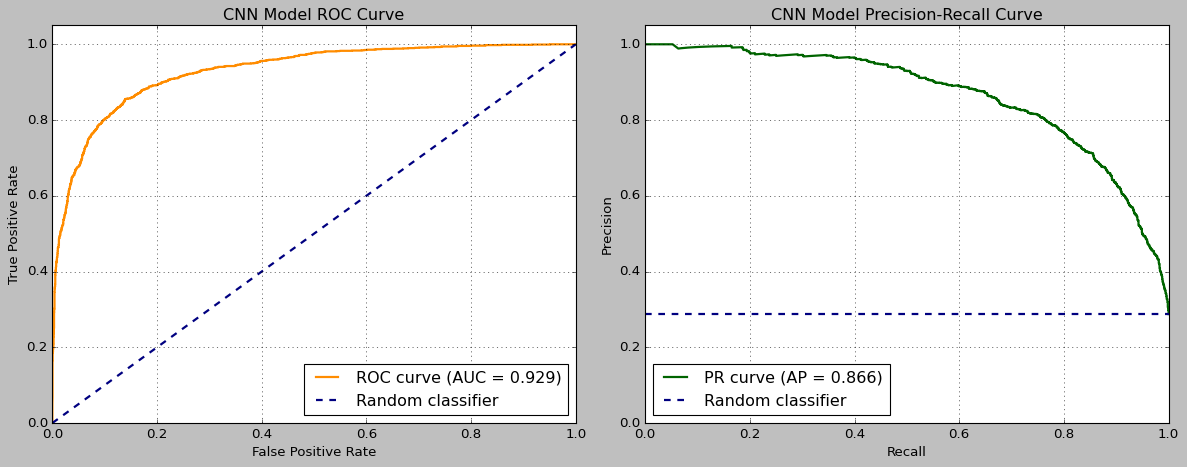

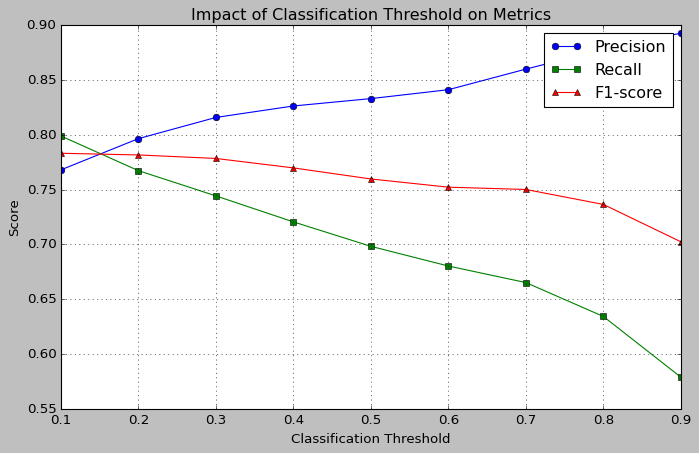


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9287

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8663

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.10
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.768, Recall=0.799, F1=0.783
   Threshold 0.2: Precision=0.796, Recall=0.767, F1=0.782
   Threshold 0.3: Precision=0.816, Recall=0.744, F1=0.778
   Threshold 0.4: Precision=0.826, Recall=0.721, F1=0.770
   Threshold 0.5: Precision=0.833, Recall=0.698, F1=0.760
   Threshold 0.6: Precision=0.841, Recall=0.680, F1=0.752
   Threshold 0.7: Precision=0.860, Recall=0.665, F1=0.750
   Threshold 0.8: Precision=0.878, Recall=0.634, F1=0.736
   Threshold 0.9: Precision=0.893, Recall=0.579, F1=0.702
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Cross-Validation Results:
Accuracy: 0.9359 ± 0.0101
Precision: 0.9116 ± 0.0246
Recall: 0.9665 ± 0.0087
F1: 0.9380 ± 0.0088

Test Set

In [5]:
cv_scores_ros, test_scores_ros, best_cnn_model_ros, history_model_ros = kfold_model_performance(
    final_df_ambient, build_model_fn=build_resnet, augmentation_fn=apply_ros, 
    window_size=11, step_size=1
)

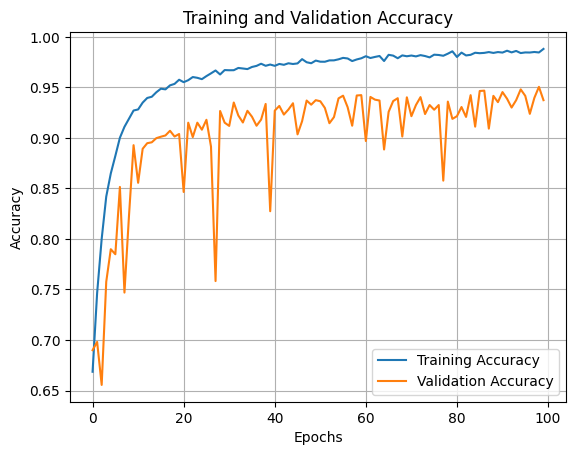

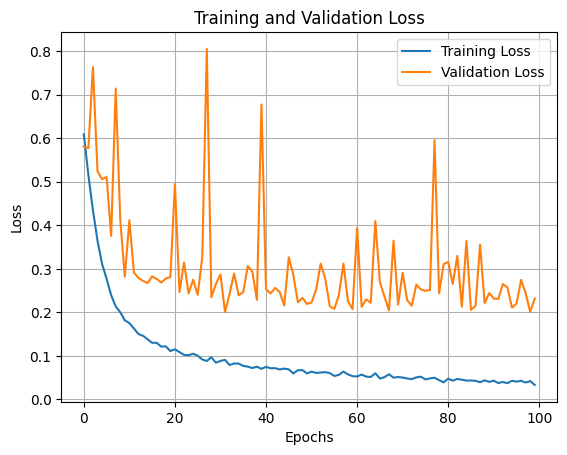

In [7]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plt.style.use('default')

plot_accuracy(history_model_ros)
plot_loss(history_model_ros)

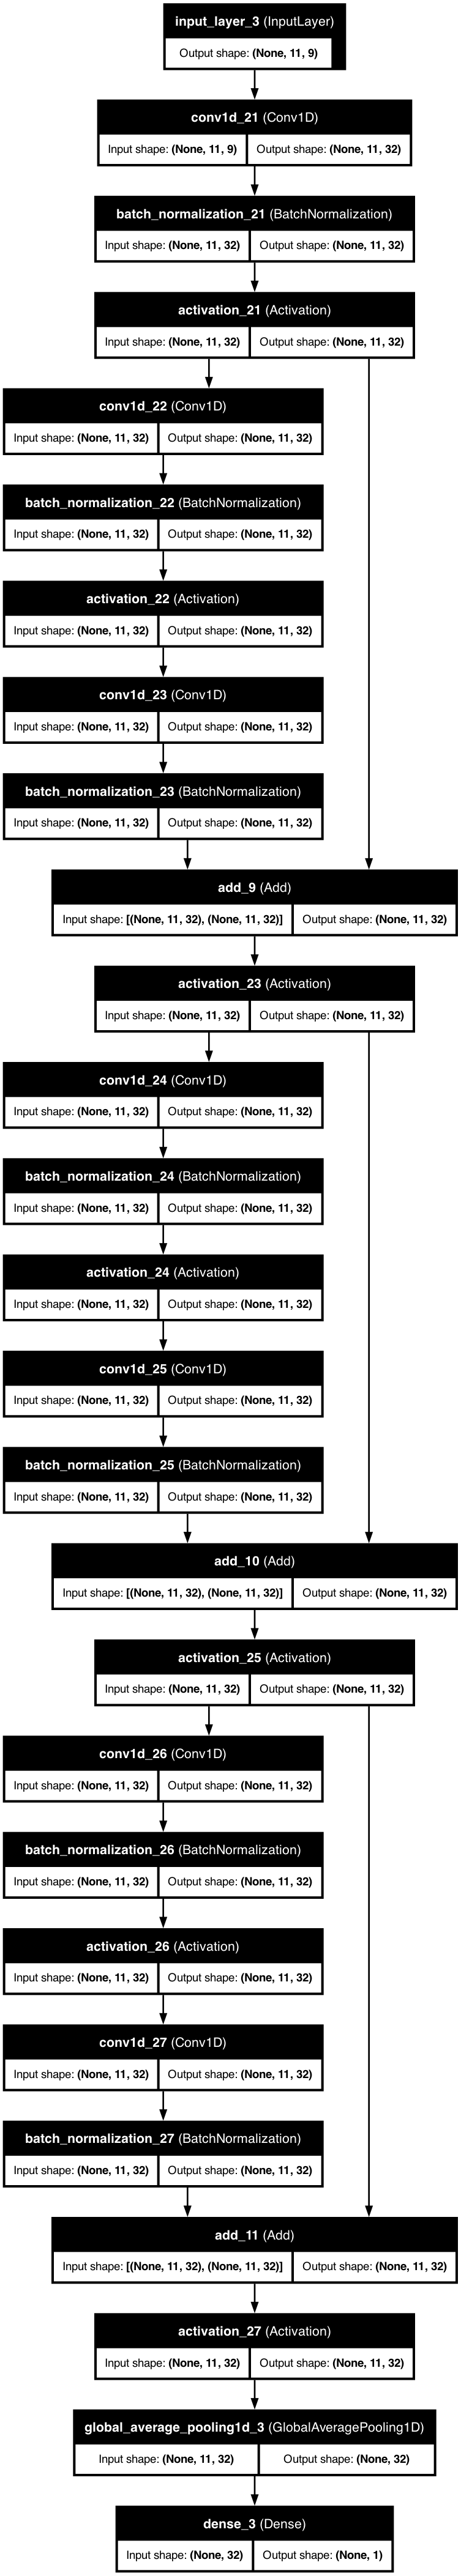

In [8]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created
plot_model(best_cnn_model_ros, to_file='cnnlstm-arch.png', 
           show_shapes=True, 
           show_layer_names=True, 
           rankdir='TB', 
           dpi=96)

In [ ]:
cv_scores_ada, test_scores_ada, best_cnn_model_ada, history_model_ada = kfold_model_performance(
    final_df_ambient, build_model_fn=build_resnet, 
    augmentation_fn=None, gan_fn=apply_gan_augmentation, 
    window_size=11, step_size=1
)